In [7]:
import sys
import math
import time
from pathlib import Path
from typing import Callable, Tuple

import torch
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader
from hyper_rbm import SymmetricHyperRBM, train_loop, get_sigmoid_curve


data_dir = Path("measurements")
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
print(f"Running on: {device}")

Running on: cpu


In [8]:
def compute_mz_abs(samples: torch.Tensor) -> Tuple[float, float]:
    # convert spins into +1/-1 domain, take absolute mean per sample then batch
    spins_pm = 1.0 - 2.0 * samples.float()
    mz_per_sample = spins_pm.mean(dim=1)
    mz_abs = mz_per_sample.abs()

    total_mz = mz_abs.mean().item()
    total_mz_err = mz_abs.std(unbiased=True).item() / math.sqrt(samples.shape[0])
    return total_mz, total_mz_err

def compute_mx(samples: torch.Tensor, log_score_fn: Callable[[torch.Tensor], torch.Tensor]) -> Tuple[float, float]:

    B, N = samples.shape
    with torch.no_grad():
        log_scores_orig = log_score_fn(samples)
        total_ratios = torch.zeros(B, device=samples.device, dtype=torch.float32)

        # iterate over all sites in batch manner and calculate ratios in log space. accumulate all site ratios
        for i in range(N):
            flipped_samples = samples.clone()
            flipped_samples[:, i] = 1 - flipped_samples[:, i]
            log_scores_flip = log_score_fn(flipped_samples)
            log_ratios = log_scores_flip - log_scores_orig
            total_ratios += torch.exp(log_ratios)

        avg_mx_per_sample = total_ratios / N
        total_mx = avg_mx_per_sample.mean().item()
        total_mx_err = avg_mx_per_sample.std(unbiased=True).item() / math.sqrt(B)
        return total_mx, total_mx_err

In [9]:
SIDE_LENGTH = 4
FILE_SAMPLE_COUNT = 20_000
TRAIN_SAMPLE_COUNT = 20_000

h_support = [1.00, 2.00, 3.00, 4.00, 5.00, 6.00, 7.00]
h_novel_int = []
h_novel_fill = [1.50, 1.80, 2.20, 2.40, 2.60, 2.80, 3.20, 3.40, 3.60, 3.80, 4.20, 4.50, 5.50, 6.50]
h_novel = sorted(h_novel_int + h_novel_fill)
all_h_values = sorted(list(set(h_support + h_novel)))

file_names = [f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLE_COUNT}.npz" for h in h_support]
file_paths = [data_dir / fn for fn in file_names]

print(f"Support points: {h_support}")
print(f"Training on {TRAIN_SAMPLE_COUNT} samples per support point.")

samples_per_support = [TRAIN_SAMPLE_COUNT] * len(file_paths)
dataset = MeasurementDataset(file_paths, load_measurements_npz, ["h"], samples_per_support)

Support points: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
Training on 20000 samples per support point.


In [10]:
N_EPOCHS = 50
BATCH_SIZE = 1024
NUM_HIDDEN = 64
HYPER_NET_WIDTH = 64
K_STEPS = 10
GIBBS_NOISE_FRAC = 0.1
INIT_LR = 1e-2
FINAL_LR = 1e-4

seed = 42
torch.manual_seed(seed)
rng = torch.Generator().manual_seed(seed)

loader = MeasurementLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, rng=rng)

model = SymmetricHyperRBM(num_v=dataset.num_qubits, num_h=NUM_HIDDEN,
                          hyper_dim=HYPER_NET_WIDTH, k=K_STEPS).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=INIT_LR)
scheduler = get_sigmoid_curve(INIT_LR, FINAL_LR, N_EPOCHS*len(loader), 0.005)

model = train_loop(model, optimizer, loader, num_epochs=N_EPOCHS,
                   lr_schedule_fn=scheduler, noise_frac=GIBBS_NOISE_FRAC, rng=rng)

Epoch  | Loss       | LR        
-----------------------------------
1      | +0.0395     | 0.010000
10     | +0.0054     | 0.010000
20     | +0.0084     | 0.009689
30     | -0.0032     | 0.000414
40     | -0.0065     | 0.000100
50     | -0.0067     | 0.000100


In [11]:
ref_file = Path(f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_magnet_ref.csv")
ref_df = pd.read_csv(ref_file)
print(f"Loaded ED reference data from: {ref_file.name}\n")

SAMPLES_EVAL = 10_000
K_STEPS_EVAL = 10
RNG_EVAL = torch.Generator(device=device).manual_seed(42)

sweep = sorted([(h, "support") for h in h_support] + [(h, "novel") for h in h_novel], key=lambda x: x[0])

print(f"Evaluating magnetizations over {len(sweep)} field values...")
results = []

# constant temperature schedule at T=1.0 during generation
schedule_tensor = torch.tensor([1.0] * K_STEPS_EVAL, device=device, dtype=torch.float32)

for h_val, kind in sweep:
    cond_batch = torch.full((SAMPLES_EVAL, 1), h_val, device=device, dtype=torch.float32)

    samples = model.generate(cond_batch, T_schedule=schedule_tensor, rng=RNG_EVAL)

    # scorer wrapper for Mx calculation
    scorer = lambda v: model.log_score(v, cond_batch)

    mz, _ = compute_mz_abs(samples)
    mx, _ = compute_mx(samples, scorer)

    results.append({"h": h_val, "type": kind, "mz": mz, "mx": mx})
    print(f"h {h_val:5.2f} [{kind:7}] | |Mz|: {mz:.5f} | Mx: {mx:.5f}")

magnet_df = pd.DataFrame(results).sort_values("h")

Loaded ED reference data from: tfim_4x4_magnet_ref.csv

Evaluating magnetizations over 21 field values...
h  1.00 [support] | |Mz|: 0.96766 | Mx: 0.25171
h  1.50 [novel  ] | |Mz|: 0.93111 | Mx: 0.36188
h  1.80 [novel  ] | |Mz|: 0.88779 | Mx: 0.45431
h  2.00 [support] | |Mz|: 0.84260 | Mx: 0.52759
h  2.20 [novel  ] | |Mz|: 0.78415 | Mx: 0.60691
h  2.40 [novel  ] | |Mz|: 0.71055 | Mx: 0.68611
h  2.60 [novel  ] | |Mz|: 0.62884 | Mx: 0.75967
h  2.80 [novel  ] | |Mz|: 0.54529 | Mx: 0.82202
h  3.00 [support] | |Mz|: 0.47030 | Mx: 0.87145
h  3.20 [novel  ] | |Mz|: 0.41749 | Mx: 0.90290
h  3.40 [novel  ] | |Mz|: 0.37634 | Mx: 0.92345
h  3.60 [novel  ] | |Mz|: 0.34709 | Mx: 0.93837
h  3.80 [novel  ] | |Mz|: 0.32232 | Mx: 0.94956
h  4.00 [support] | |Mz|: 0.30546 | Mx: 0.95833
h  4.20 [novel  ] | |Mz|: 0.29465 | Mx: 0.96302
h  4.50 [novel  ] | |Mz|: 0.28165 | Mx: 0.96929
h  5.00 [support] | |Mz|: 0.26992 | Mx: 0.97533
h  5.50 [novel  ] | |Mz|: 0.25999 | Mx: 0.98106
h  6.00 [support] | |Mz|: 0.24

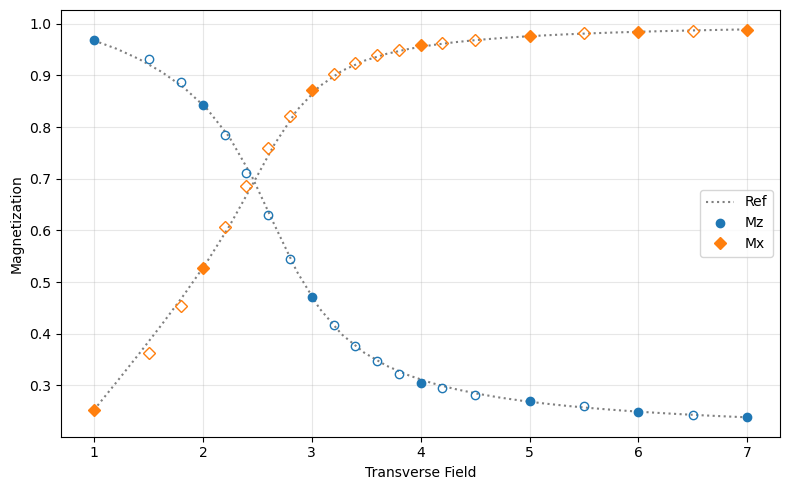

In [12]:
support_df = magnet_df[magnet_df["type"] == "support"]
novel_df = magnet_df[magnet_df["type"] == "novel"]

plt.figure(figsize=(8, 5), dpi=100)

plt.plot(ref_df["h"], ref_df["mag_z"], ':', color='gray', label="Ref")
plt.plot(ref_df["h"], ref_df["mag_x"], ':', color='gray')

plt.plot(support_df["h"], support_df["mz"], 'o', color='tab:blue', label="Mz")
plt.plot(novel_df["h"], novel_df["mz"], 'o', color='tab:blue', mfc='none')

plt.plot(support_df["h"], support_df["mx"], 'D', color='tab:orange', label="Mx")
plt.plot(novel_df["h"], novel_df["mx"], 'D', color='tab:orange', mfc='none')

plt.xlabel("Transverse Field")
plt.ylabel("Magnetization")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
timestamp = time.strftime("%Y%m%d_%H%M%S")
file_name = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_magnet_many_rbm_{timestamp}.csv"
save_path = results_dir / file_name

magnet_df.to_csv(save_path, index=False, float_format="%.6f")
print(f"Saved RBM magnetizations to: {save_path}")

Saved RBM magnetizations to: results/tfim_4x4_magnet_many_rbm_20260120_164445.csv
